### 📦 Importing Required Libraries and Configuring PySpark Environment

This cell imports essential libraries for data manipulation, machine learning, and visualization using PySpark, Matplotlib, and Seaborn. It also sets up environment variables to explicitly define the Python executable for PySpark and suppresses warnings to keep the output clean.


In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, isnan, when, count, udf, to_timestamp, month, dayofmonth, quarter, dayofweek, date_format
from pyspark.sql.types import IntegerType, FloatType, StringType, DateType
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import io
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import rand
import warnings
import os
warnings.filterwarnings("ignore") # Suppress warnings
os.environ["PYSPARK_PYTHON"] = "C:/Users/sab00/AppData/Local/Programs/Python/Python310/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:/Users/sab00/AppData/Local/Programs/Python/Python310/python.exe"


### 🚀 Initializing Spark Session

This cell creates a Spark session named `FlightDataAnalysis` with local execution and 2 GB driver memory. It also sets the log level to "ERROR" to reduce verbose Spark output.


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("FlightDataAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

### 📂 Loading Datasets and Previewing Data

This cell reads three CSV files—`flights`, `weather`, and `airport locations`—into Spark DataFrames with headers and inferred schemas. It then prints the column names and displays the first 5 rows from each dataset to provide a quick overview.


In [3]:
flights_df = spark.read.option("header", True).option("inferSchema", True).csv("US_flights_2023.csv")
weather_df = spark.read.option("header", True).option("inferSchema", True).csv("weather_meteo_by_airport.csv")
location_df = spark.read.option("header", True).option("inferSchema", True).csv("airports_geolocation.csv")

In [4]:
print("Columns in flights_df:\n", flights_df.columns)
print("\n\nColumns in weather_df:\n", weather_df.columns)
print("\n\nColumns in location_df:\n", location_df.columns)

print("\nFlights data sample:")
flights_df.show(5)

print("\nWeather data sample:")
weather_df.show(5)

print("\nLocation data sample:")
location_df.show(5)

Columns in flights_df:
 ['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay', 'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Manufacturer', 'Model', 'Aicraft_age']


Columns in weather_df:
 ['time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'airport_id']


Columns in location_df:
 ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE']

Flights data sample:
+----------+-----------+------------+-----------+-----------+------------+-------------+---------+-------------+--------------+-----------+------------+---------+--------------+---------------+------------------+-------------+-------------+---------+--------------+------------------+--------------------+-----+-----------+
|FlightDate|Day_Of_Week|     Airlin

### 🔗 Merging Datasets on Date and Airport Information

This cell first converts the `FlightDate` and `time` columns to timestamp format to enable accurate joins. It then merges:
- `flights_df` with `weather_df` using departure airport and flight date,
- and the resulting DataFrame with `location_df` using airport codes.

Finally, it randomly samples 20,000 rows for further analysis and prints the schema of the merged dataset.


In [5]:
flights_df = flights_df.withColumn("FlightDate", to_timestamp(col("FlightDate"), "yyyy-MM-dd"))
weather_df = weather_df.withColumn("time", to_timestamp(col("time"), "yyyy-MM-dd"))

# Merge dataframes
merged_df = flights_df.join(
    weather_df,
    (flights_df["Dep_Airport"] == weather_df["airport_id"]) & 
    (flights_df["FlightDate"] == weather_df["time"]),
    "left"
)

final_df = merged_df.join(
    location_df,
    merged_df["Dep_Airport"] == location_df["IATA_CODE"],
    "left"
)
final_df=final_df.orderBy(rand()).limit(20000)
print("Merged data schema:")
final_df.printSchema()


Merged data schema:
root
 |-- FlightDate: timestamp (nullable = true)
 |-- Day_Of_Week: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Dep_Airport: string (nullable = true)
 |-- Dep_CityName: string (nullable = true)
 |-- DepTime_label: string (nullable = true)
 |-- Dep_Delay: integer (nullable = true)
 |-- Dep_Delay_Tag: integer (nullable = true)
 |-- Dep_Delay_Type: string (nullable = true)
 |-- Arr_Airport: string (nullable = true)
 |-- Arr_CityName: string (nullable = true)
 |-- Arr_Delay: integer (nullable = true)
 |-- Arr_Delay_Type: string (nullable = true)
 |-- Flight_Duration: integer (nullable = true)
 |-- Distance_type: string (nullable = true)
 |-- Delay_Carrier: integer (nullable = true)
 |-- Delay_Weather: integer (nullable = true)
 |-- Delay_NAS: integer (nullable = true)
 |-- Delay_Security: integer (nullable = true)
 |-- Delay_LastAircraft: integer (nullable = true)
 |-- Manufacturer: string (nullable = 

### ⚖️ Balancing Classes for Flight Delay Prediction

This cell filters the dataset into two classes based on the `Dep_Delay_Tag` column—Class 0 (No Delay) and Class 1 (Delay). It then:
- Counts the number of rows in each class,
- Samples 7,000 rows from each class to ensure balance,
- Combines the samples and shuffles the final DataFrame.

Lastly, it checks and prints the class distribution after balancing to confirm equal representation of both classes.


In [6]:
class_0 = final_df.filter(col("Dep_Delay_Tag") == 0)
class_1 = final_df.filter(col("Dep_Delay_Tag") == 1)

# Count the number of rows in each class
count_class_0 = class_0.count()
count_class_1 = class_1.count()
print(f"Class 0 (No Delay) count: {count_class_0}")
print(f"Class 1 (Delay) count: {count_class_1}")

# Set the sample size
min_count = 7000

print(f"Using {min_count} samples per class")

class_0_sample = class_0.orderBy(rand()).limit(min_count)
class_1_sample = class_1.orderBy(rand()).limit(min_count)

# Combine and shuffle
balanced_df = class_0_sample.union(class_1_sample)
balanced_df = balanced_df.orderBy(rand(seed=42))

# Check balance
print("Class distribution after balancing:")
balanced_df.groupBy("Dep_Delay_Tag").count().show()

Class 0 (No Delay) count: 12346
Class 1 (Delay) count: 7654
Using 7000 samples per class
Class distribution after balancing:
+-------------+-----+
|Dep_Delay_Tag|count|
+-------------+-----+
|            0| 7000|
|            1| 7000|
+-------------+-----+



### 📅 Feature Engineering: Adding Time-related Features and Cleaning Data

This cell adds new time-related features to the dataset, including the `Month`, `Day`, and `Quarter` extracted from the `FlightDate`. It also:
- Defines and registers user-defined functions (UDFs) to map day and month numbers to their respective names,
- Applies these UDFs to create the `Day_Of_Week` and `Month_Name` columns,
- Finally, drops unnecessary columns (`airport_id`, `IATA_CODE`, `time`, and `COUNTRY`) to clean up the dataset.


In [7]:
balanced_df = balanced_df.withColumn("Month", month(col("FlightDate"))) \
                        .withColumn("Day", dayofmonth(col("FlightDate"))) \
                        .withColumn("Quarter", quarter(col("FlightDate")))

# Define mapping functions for day and month names
def day_name(day_num):
        day_mapping = {
            1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 
            5: "Friday", 6: "Saturday", 7: "Sunday"
        }
        return day_mapping.get(day_num, "Unknown")
    
def month_name(month_num):
        try:
            return datetime.date(2023, month_num, 1).strftime('%B')
        except:
            return "Unknown"

# Register UDFs
day_name_udf = udf(day_name, StringType())
month_name_udf = udf(month_name, StringType())

# Apply UDFs
balanced_df = balanced_df.withColumn("Day_Of_Week", day_name_udf(col("Day_Of_Week")))
balanced_df = balanced_df.withColumn("Month_Name", month_name_udf(col("Month")))
# Drop unnecessary columns
columns_to_drop = ["airport_id", "IATA_CODE", "time", "COUNTRY"]
balanced_df = balanced_df.drop(*columns_to_drop)

### 🔍 Handling Missing Values and Duplicates

This cell performs several key data cleaning operations:
1. **Count Null Values**: It defines a function `count_nulls` to check for missing values in each column, including handling numeric and string columns with appropriate conditions.
2. **Fill Missing Values**: It then fills missing values in numeric columns with 0 and in string columns with "Unknown".
3. **Duplicate Removal**: Finally, it checks for duplicate rows in the dataset and removes them if any duplicates are found.

This ensures the dataset is ready for further processing without missing or redundant data.


In [8]:
from pyspark.sql.functions import col, isnan

def count_nulls(df):
    null_counts = []
    for col_name in df.columns:
        dtype = df.schema[col_name].dataType.simpleString()
        if dtype in ['double', 'float', 'integer', 'long']:
            condition = col(col_name).isNull() | isnan(col(col_name))
        elif dtype == 'string':
            condition = col(col_name).isNull() | (col(col_name) == "")
        else:
            condition = col(col_name).isNull()
        null_count = df.filter(condition).count()
        null_counts.append((col_name, null_count))
    return null_counts

missing = count_nulls(balanced_df)
print("Null Values:")
for col_name, null_count in missing:
    if null_count > 0:
        print(f"{col_name}: {null_count}")

# Handle missing values
for column in balanced_df.columns:
    data_type = balanced_df.schema[column].dataType.simpleString()
    if data_type in ['double', 'float', 'integer', 'long']:
        balanced_df = balanced_df.withColumn(
            column, 
            when(col(column).isNull() | isnan(column), 0).otherwise(col(column))
        )
    elif data_type == 'string':
        balanced_df = balanced_df.withColumn(
            column, 
            when(col(column).isNull() | (col(column) == ""), "Unknown").otherwise(col(column))
        )

# Check for duplicates
duplicate_count = balanced_df.count() - balanced_df.dropDuplicates().count()
print(f"Number of duplicates: {duplicate_count}")

# Remove duplicates if any
if duplicate_count > 0:
    balanced_df = balanced_df.dropDuplicates()


Null Values:
Number of duplicates: 0


### 🏷️ Identifying Numerical and Categorical Columns

This cell identifies and separates the columns in the `balanced_df` into numerical and categorical categories. It:
- Excludes `Dep_Delay_Tag` and `FlightDate` from categorization,
- Classifies columns with numeric types (`int`, `bigint`, `double`, `float`) as numerical, 
- Classifies columns with `string` data type as categorical.

It then prints the names and counts of numerical and categorical columns for further analysis.


In [9]:
numerical_cols = []
categorical_cols = []

for col_name, data_type in balanced_df.dtypes:
    if col_name != "Dep_Delay_Tag" and col_name != "FlightDate":
        if data_type in ['int', 'bigint', 'double', 'float']:
            numerical_cols.append(col_name)
        elif data_type == 'string':
            categorical_cols.append(col_name)

print(f"Numerical Columns: {numerical_cols} with count of {len(numerical_cols)}")
print(f"Categorical Columns: {categorical_cols} with count of {len(categorical_cols)}")

Numerical Columns: ['Dep_Delay', 'Arr_Delay', 'Flight_Duration', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'LATITUDE', 'LONGITUDE', 'Month', 'Day', 'Quarter'] with count of 22
Categorical Columns: ['Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay_Type', 'Distance_type', 'Manufacturer', 'Model', 'AIRPORT', 'CITY', 'STATE', 'Month_Name'] with count of 17


### 📊 Analyzing Categorical Columns with Few Unique Values

This cell analyzes the categorical columns that have fewer than 40 unique values. For each of these columns, it:
- Prints the number of unique values,
- Displays the top 10 most frequent values along with their counts.

This helps identify key categorical features with limited cardinality for further exploration or encoding.


In [10]:
for col in categorical_cols:
    distinct_count = balanced_df.select(col).distinct().count()
    if distinct_count < 40:
        print(f"{col}: {distinct_count} unique values")
        balanced_df.groupBy(col).count().orderBy("count", ascending=False).show(10)
        print("-" * 80)

Day_Of_Week: 7 unique values
+-----------+-----+
|Day_Of_Week|count|
+-----------+-----+
|   Thursday| 2149|
|     Monday| 2130|
|     Friday| 2113|
|     Sunday| 2068|
|  Wednesday| 1940|
|    Tuesday| 1860|
|   Saturday| 1740|
+-----------+-----+

--------------------------------------------------------------------------------
Airline: 15 unique values
+--------------------+-----+
|             Airline|count|
+--------------------+-----+
|Southwest Airline...| 3175|
| Delta Air Lines Inc| 1996|
|American Airlines...| 1938|
|United Air Lines ...| 1449|
|Skywest Airlines ...| 1320|
|     JetBlue Airways|  621|
|    Republic Airways|  563|
|    Spirit Air Lines|  532|
|Alaska Airlines Inc.|  481|
|American Eagle Ai...|  426|
+--------------------+-----+
only showing top 10 rows

--------------------------------------------------------------------------------
DepTime_label: 4 unique values
+-------------+-----+
|DepTime_label|count|
+-------------+-----+
|      Morning| 5112|
|    Aftern

### 📈 Statistical Summary for Numerical Columns

This cell generates descriptive statistics for each numerical column, including:
- Count, minimum, 25th percentile, median (50th percentile), 75th percentile, and maximum values.

These statistics provide an overview of the distribution and range of values for each numerical feature in the dataset.


In [11]:
for col in numerical_cols:
    print(f"Statistics for {col}:")
    balanced_df.select(col).summary("count", "min", "25%", "50%", "75%", "max").show()
    print("-" * 80)

Statistics for Dep_Delay:
+-------+---------+
|summary|Dep_Delay|
+-------+---------+
|  count|    14000|
|    min|      -28|
|    25%|       -5|
|    50%|        0|
|    75%|       17|
|    max|     2295|
+-------+---------+

--------------------------------------------------------------------------------
Statistics for Arr_Delay:
+-------+---------+
|summary|Arr_Delay|
+-------+---------+
|  count|    14000|
|    min|      -67|
|    25%|      -13|
|    50%|       -3|
|    75%|       16|
|    max|     2281|
+-------+---------+

--------------------------------------------------------------------------------
Statistics for Flight_Duration:
+-------+---------------+
|summary|Flight_Duration|
+-------+---------------+
|  count|          14000|
|    min|             21|
|    25%|             87|
|    50%|            124|
|    75%|            172|
|    max|            681|
+-------+---------------+

--------------------------------------------------------------------------------
Statistics

### 🎨 Sample for Visualization

This cell takes a 5% random sample (without replacement) of the `balanced_df` dataset for visualization purposes. It then converts this sample into a Pandas DataFrame to facilitate plotting and analysis. The number of samples selected is printed for reference.


In [12]:
viz_sample = balanced_df.sample(False, 0.05, seed=42).toPandas()
print(f"Using {len(viz_sample)} samples for visualization")


Using 694 samples for visualization


### 📊 Visualizing the Distribution of Flight Delays

This cell creates a count plot to visualize the distribution of flight delays (`Dep_Delay_Tag`), showing the count of delayed and on-time flights. The plot is saved as `delay_distribution.png` and displayed. The `hue` parameter is set to the delay status to highlight the categories within the plot.


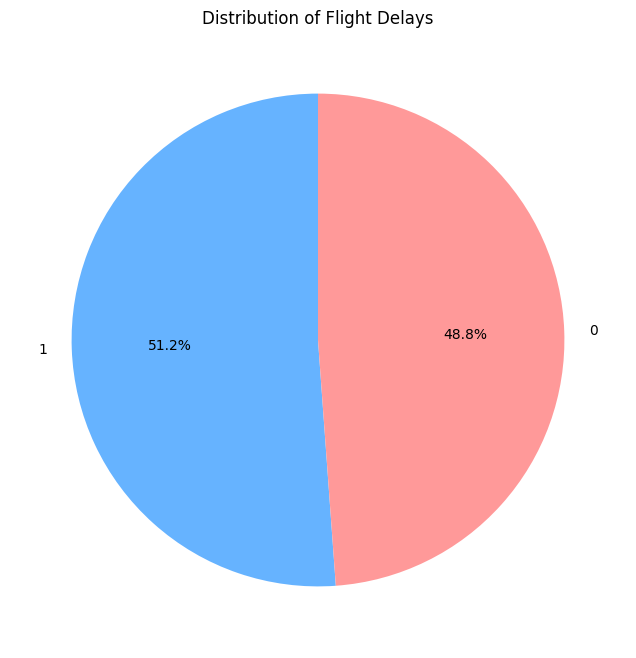

In [13]:
delay_counts = viz_sample['Dep_Delay_Tag'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(delay_counts, labels=delay_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Flight Delays')
plt.ylabel('')  # No label needed for the y-axis
plt.savefig('delay_distribution_pie_chart.png')
plt.show()

### 📅 Visualizing Flight Delays by Day of the Week

This cell creates a count plot to visualize flight delays across different days of the week. The plot shows the distribution of on-time and delayed flights for each day, with the days ordered from Monday to Sunday. The plot is saved as `delays_by_day.png` and displayed. The `hue` is used to distinguish between delayed and on-time flights.

The x-axis represents the days of the week, while the y-axis shows the count of flights for each category.


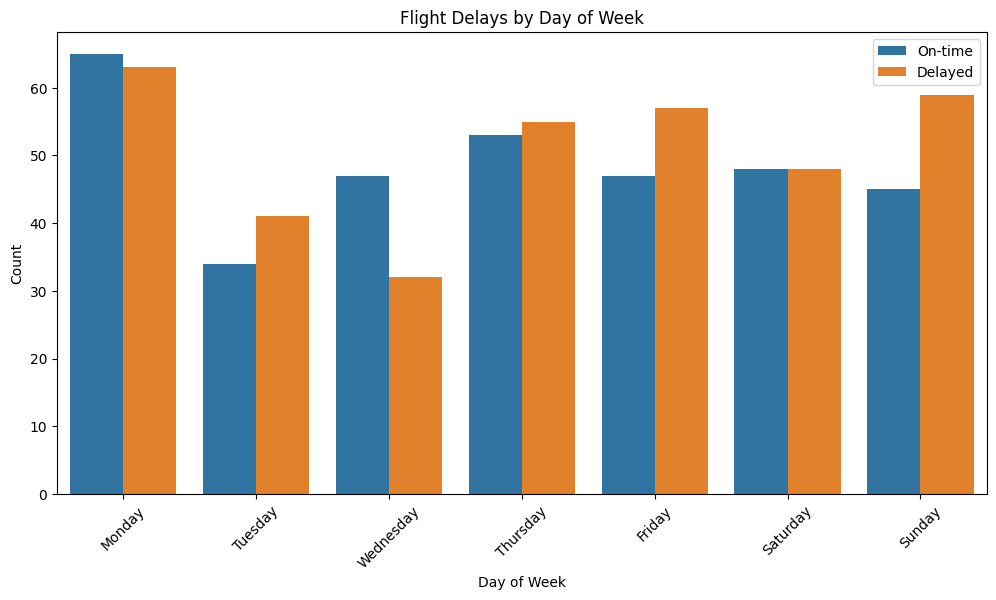

In [14]:
plt.figure(figsize=(12, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='Day_Of_Week', hue='Dep_Delay_Tag', data=viz_sample, order=order)
plt.title('Flight Delays by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(['On-time', 'Delayed'])
plt.xticks(rotation=45)
plt.savefig('delays_by_day.png')
plt.show()

### 📅 Visualizing Flight Delays by Month

This cell generates a count plot to visualize the distribution of flight delays across different months. The plot shows the count of on-time and delayed flights for each month, ordered from January to December. The plot is saved as `delays_by_month.png` and displayed. The `hue` parameter distinguishes between delayed and on-time flights.

The x-axis represents the months of the year, and the y-axis shows the count of flights for each category.


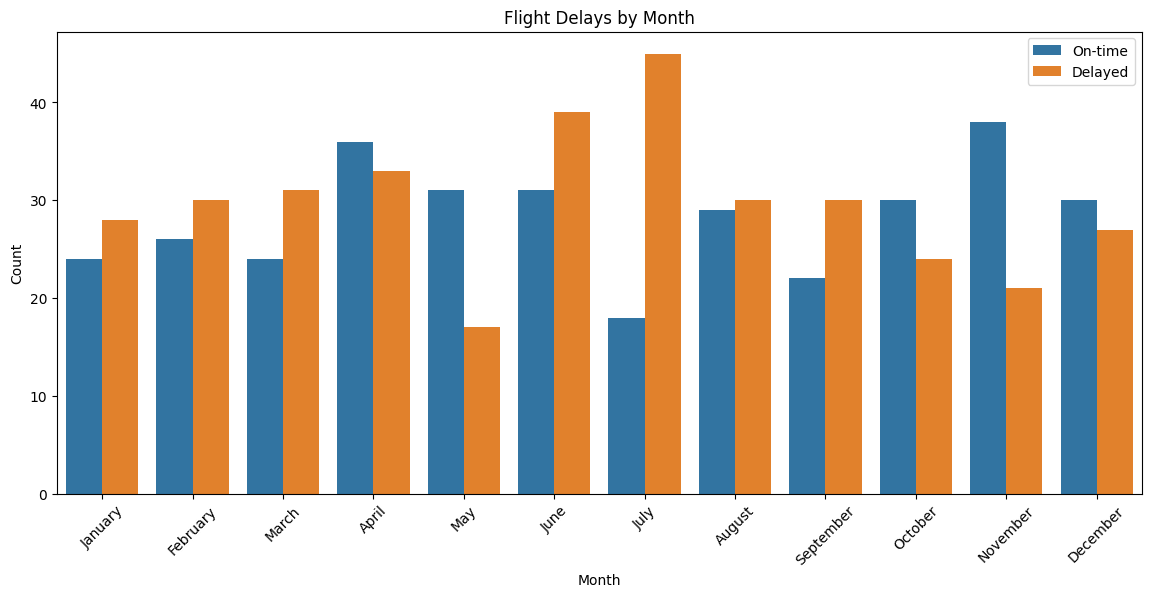

In [15]:
plt.figure(figsize=(14, 6))
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(x='Month_Name', hue='Dep_Delay_Tag', data=viz_sample, order=month_order)
plt.title('Flight Delays by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(['On-time', 'Delayed'])
plt.xticks(rotation=45)
plt.savefig('delays_by_month.png')
plt.show()

### 🔥 Correlation Heatmap of Numerical Features

This cell calculates the correlation between the numerical features in the dataset and visualizes the correlation matrix using a heatmap. The heatmap is displayed with annotations showing the correlation coefficients, with the upper triangle masked for better readability. The plot is saved as `correlation_heatmap.png`.

The color scheme (`coolwarm`) highlights positive and negative correlations between features, with values annotated on the heatmap.


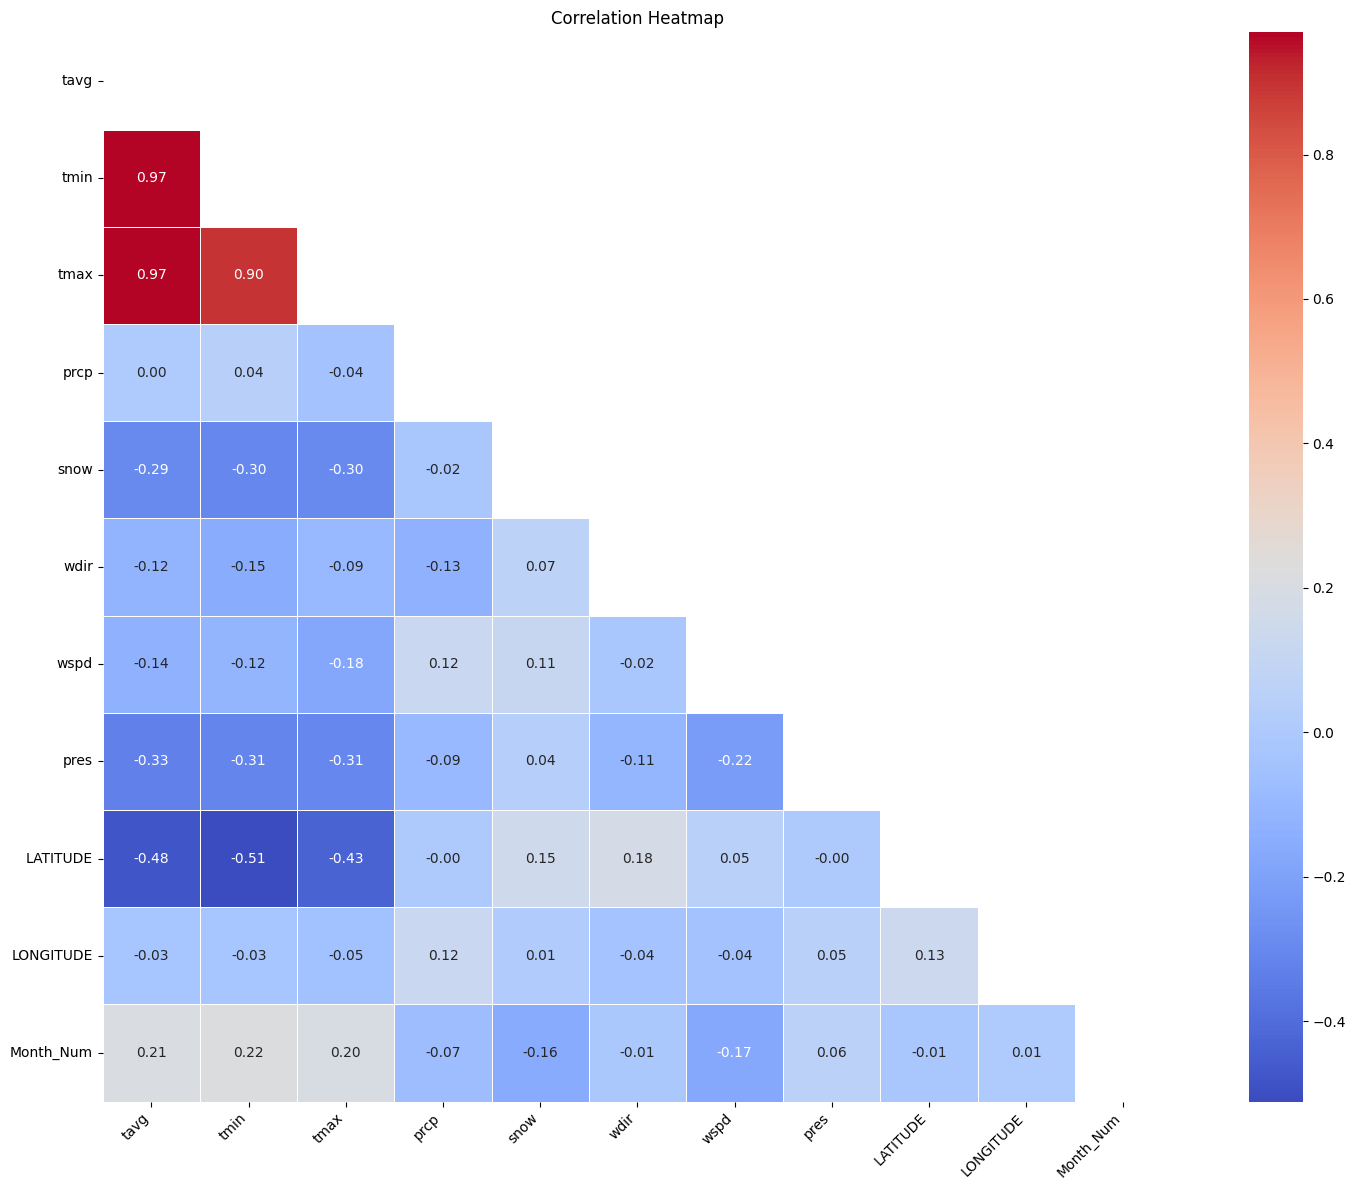

In [16]:
numeric_cols_for_corr = [col for col in viz_sample.columns 
                        if viz_sample[col].dtype in ['int64', 'float64']]

# Calculate correlations
correlation = viz_sample[numeric_cols_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
           square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

### 🌤️ Boxplot: Weather Conditions vs. Flight Delay

This cell generates boxplots to compare various weather conditions (e.g., average temperature, wind speed, precipitation) with flight delays. The plots show how these weather features relate to flight delay (on-time vs. delayed flights).

The weather features analyzed include:
- Average temperature (`tavg`)
- Minimum temperature (`tmin`)
- Maximum temperature (`tmax`)
- Wind direction (`wdir`)
- Wind speed (`wspd`)
- Pressure (`pres`)
- Precipitation (`prcp`)
- Snowfall (`snow`)

Each plot is saved as an individual PNG file (e.g., `tavg_vs_delay.png`) for further analysis.


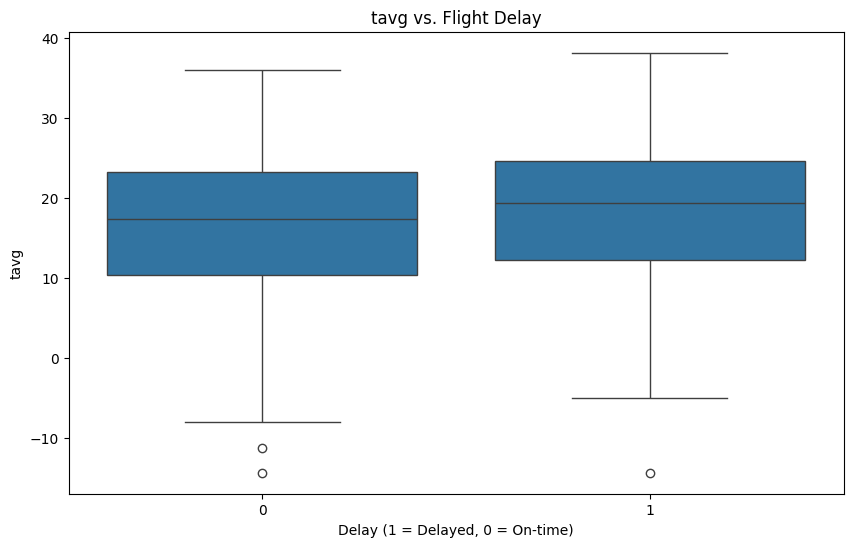

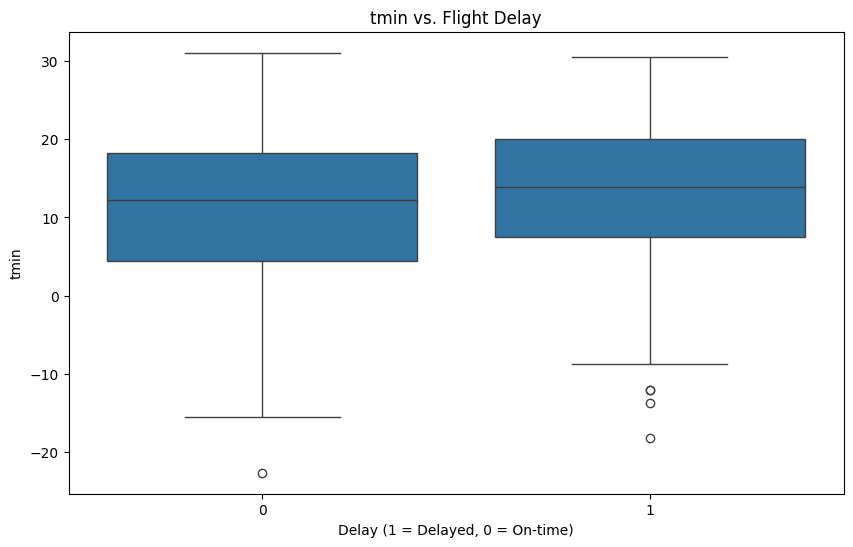

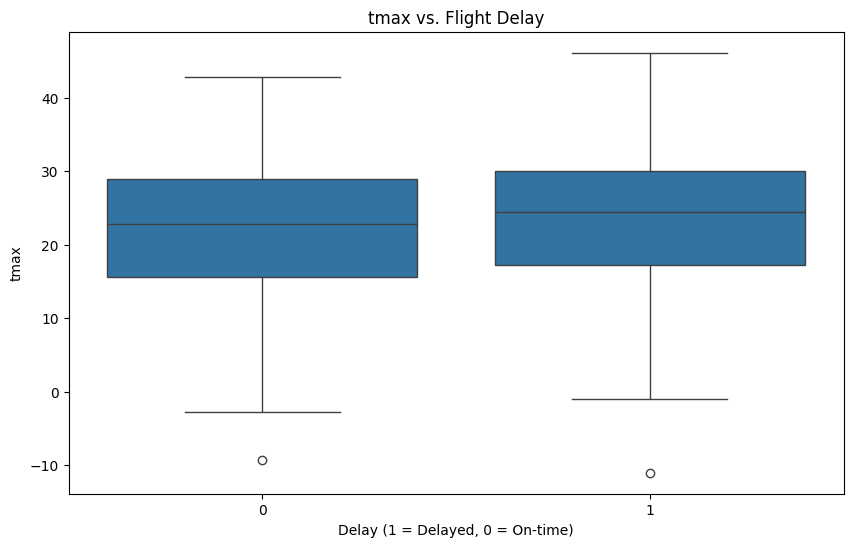

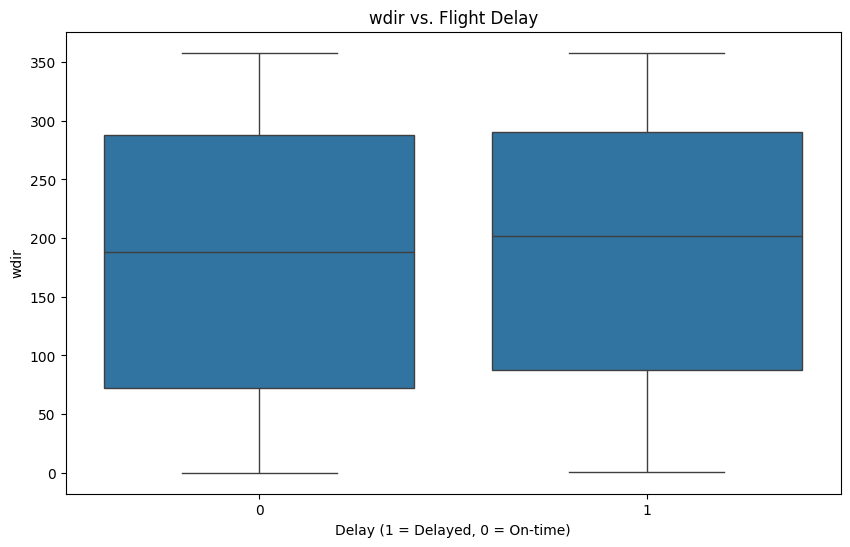

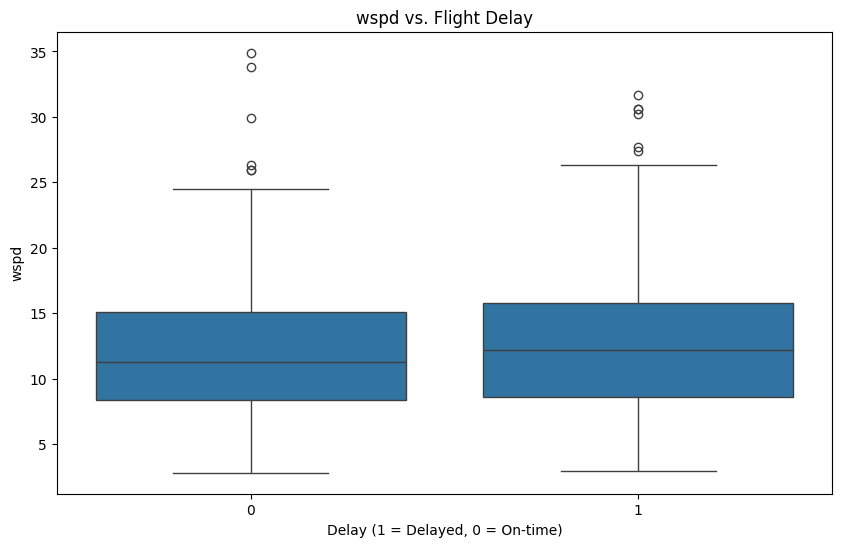

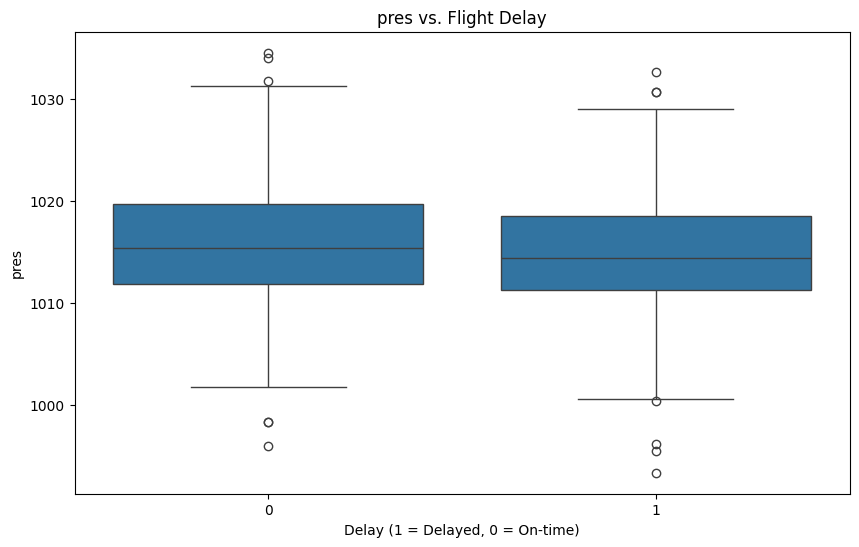

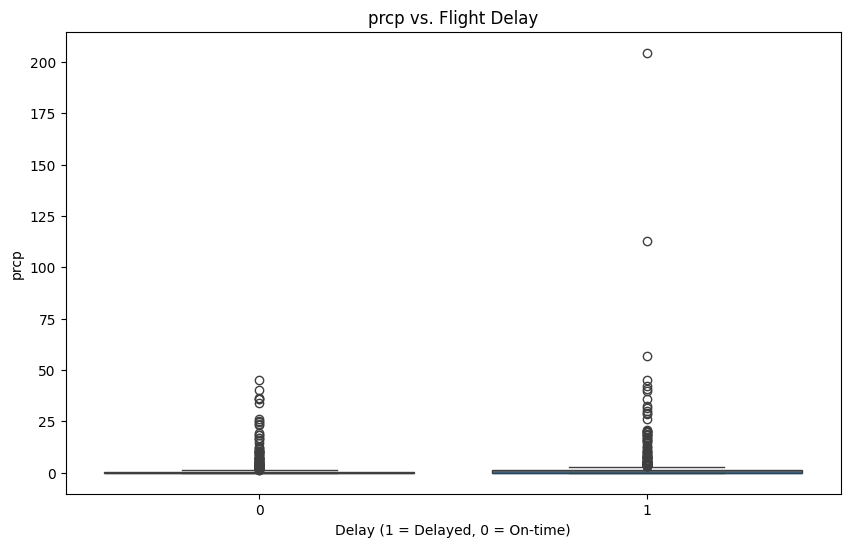

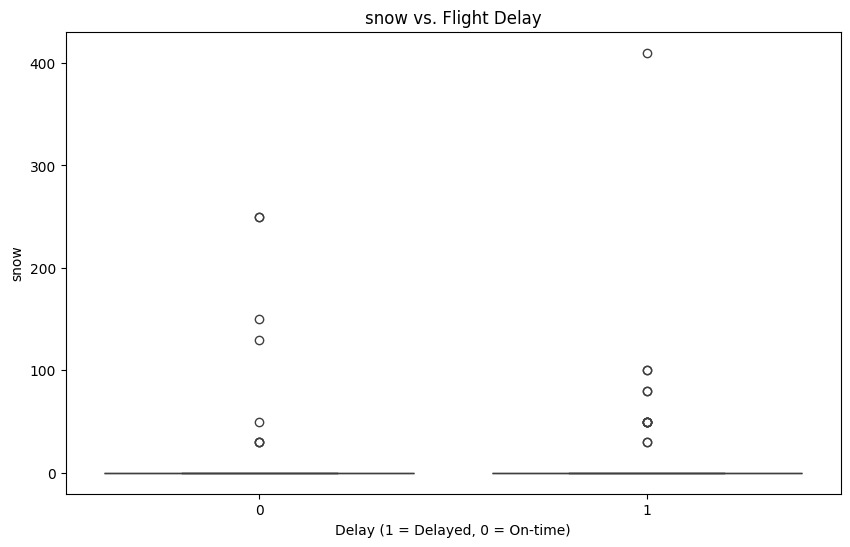

In [17]:
weather_cols = ['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres','prcp','snow']  

# Plot the first 3
for col in weather_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Dep_Delay_Tag', y=col, data=viz_sample)
    plt.title(f'{col} vs. Flight Delay')
    plt.xlabel('Delay (1 = Delayed, 0 = On-time)')
    plt.ylabel(col)
    plt.savefig(f'{col}_vs_delay.png')
    plt.show()

### 🔧 Feature Engineering Pipeline: Categorical Features

This cell sets up the initial part of a feature engineering pipeline for handling categorical features. The pipeline includes two key steps:
1. **String Indexing**: Converts categorical variables into numerical values using `StringIndexer`. This assigns a unique numeric value to each category in the feature.
2. **One-Hot Encoding**: Encodes the indexed categorical variables as binary vectors using `OneHotEncoder`. This allows the model to work with the categorical data by representing it in a format that can be used by machine learning algorithms.

Both operations are applied to each categorical feature in the dataset, and the stages are stored in a list for later use in the full pipeline.


In [18]:
balanced_df.cache()

# Prepare features pipeline - Part 1 (Categorical features)
stages = []

# Handle categorical features
for col in categorical_cols:
    # String indexing
    string_indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    # One-hot encoding
    encoder = OneHotEncoder(inputCols=[f"{col}_index"], outputCols=[f"{col}_encoded"])
    stages += [string_indexer, encoder]


### 🔧 Feature Engineering Pipeline: Assemble Features

In this cell, the pipeline is extended to include the **VectorAssembler**, which combines both the one-hot encoded categorical features and numerical features into a single feature vector. The following steps are executed:
1. **Vector Assembler**: This step combines the individual columns of encoded categorical features and numerical features into a single "features" column that can be used by machine learning models.
2. **Pipeline Creation and Fitting**: The pipeline is created using the stages defined earlier, and it's fitted to the dataset (`balanced_df`). The fitted model is then applied to the data to generate the transformed dataset with the new "features" column.

The resulting `prepared_data` contains the transformed dataset, ready for machine learning model training.


In [19]:
input_cols = [f"{col}_encoded" for col in categorical_cols] + numerical_cols
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features", handleInvalid="keep")
stages += [vector_assembler]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the data
print("Fitting feature pipeline...")
pipeline_model = pipeline.fit(balanced_df)
prepared_data = pipeline_model.transform(balanced_df)

# Show the prepared data
print("Sample of prepared data with feature vector:")
prepared_data.select("Dep_Delay_Tag", "features").show(5)

Fitting feature pipeline...
Sample of prepared data with feature vector:
+-------------+--------------------+
|Dep_Delay_Tag|            features|
+-------------+--------------------+
|            1|(6823,[1,10,546,4...|
|            1|(6823,[2,9,434,49...|
|            1|(6823,[3,7,3479,4...|
|            1|(6823,[3,13,711,4...|
|            1|(6823,[5,14,3214,...|
+-------------+--------------------+
only showing top 5 rows



### 🏋️‍♂️ Data Splitting and Caching

Here, the preprocessed dataset (`prepared_data`) is split into **training** (80%) and **testing** (20%) sets using the `randomSplit()` method. The seed is fixed to ensure reproducibility of the split.

- **Training Set**: Used to train the machine learning model.
- **Testing Set**: Used to evaluate the model's performance.

The `.cache()` method is applied to both datasets to store them in memory, enhancing the performance for iterative algorithms and subsequent stages like model training and evaluation.


In [20]:
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {train_data.count()}")
print(f"Testing set size: {test_data.count()}")

# Cache datasets for better performance
train_data.cache()
test_data.cache()

Training set size: 11172
Testing set size: 2828


DataFrame[FlightDate: timestamp, Day_Of_Week: string, Airline: string, Tail_Number: string, Dep_Airport: string, Dep_CityName: string, DepTime_label: string, Dep_Delay: int, Dep_Delay_Tag: int, Dep_Delay_Type: string, Arr_Airport: string, Arr_CityName: string, Arr_Delay: int, Arr_Delay_Type: string, Flight_Duration: int, Distance_type: string, Delay_Carrier: int, Delay_Weather: int, Delay_NAS: int, Delay_Security: int, Delay_LastAircraft: int, Manufacturer: string, Model: string, Aicraft_age: int, tavg: double, tmin: double, tmax: double, prcp: double, snow: double, wdir: double, wspd: double, pres: double, AIRPORT: string, CITY: string, STATE: string, LATITUDE: double, LONGITUDE: double, Month: int, Day: int, Quarter: int, Month_Name: string, Day_Of_Week_index: double, Day_Of_Week_encoded: vector, Airline_index: double, Airline_encoded: vector, Tail_Number_index: double, Tail_Number_encoded: vector, Dep_Airport_index: double, Dep_Airport_encoded: vector, Dep_CityName_index: double, De

### 🚀 Logistic Regression Model: Training & Prediction

1. **Model Definition**:  
   - **`featuresCol`**: The input column containing the feature vector (all predictor variables).
   - **`labelCol`**: The target column for classification, which is `Dep_Delay_Tag` (flight delay status).
   - **`maxIter`**: The maximum number of iterations the algorithm will run for model convergence.
   - **`regParam`**: Regularization parameter, which helps in preventing overfitting by penalizing larger model coefficients.

2. **Training**:  
   - The model is trained on the training dataset (`train_data`) using the parameters defined above.

3. **Predictions**:  
   - After training, the model makes predictions on the test dataset (`test_data`).

4. **Sample Predictions**:  
   - The first 5 predictions are displayed, including:
     - **`Dep_Delay_Tag`**: Actual flight delay status.
     - **`prediction`**: Predicted flight delay status.
     - **`probability`**: The model’s prediction probabilities for each class (On-time/Delayed).


In [22]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Dep_Delay_Tag",
    maxIter=10,
    regParam=0.1
)

# Train the model
print("Training Logistic Regression model...")
lr_model = lr.fit(train_data)

# Make predictions
print("Making predictions on test data...")
lr_predictions = lr_model.transform(test_data)

# Sample of predictions
print("Sample predictions:")
lr_predictions.select("Dep_Delay_Tag", "prediction", "probability").show(5)


Training Logistic Regression model...
Making predictions on test data...
Sample predictions:
+-------------+----------+--------------------+
|Dep_Delay_Tag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.52191577585726...|
|            0|       0.0|[0.94363586099956...|
|            0|       1.0|[0.23907641679704...|
|            1|       1.0|[0.04750638807314...|
|            1|       1.0|[0.05079847758683...|
+-------------+----------+--------------------+
only showing top 5 rows



### 🌳 Gradient-Boosted Trees (GBT) Model: Training & Prediction

1. **Model Definition**:
   - **`labelCol`**: The target column, which is `Dep_Delay_Tag` (flight delay status).
   - **`featuresCol`**: The input column containing the feature vector (all predictor variables).
   - **`maxIter`**: The maximum number of iterations the algorithm will run to build the decision trees.

2. **Training**:
   - The **Gradient-Boosted Trees (GBT)** model is trained using the training dataset (`train_data`) with the specified parameters.

3. **Predictions**:
   - The model then makes predictions on the test dataset (`test_data`).

4. **Sample Predictions**:
   - The first 5 predictions are displayed, which include:
     - **`Dep_Delay_Tag`**: Actual flight delay status.
     - **`prediction`**: Predicted flight delay status.
     - **`probability`**: The model's predicted probabilities for each class (On-time/Delayed).


In [23]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Dep_Delay_Tag", featuresCol="features", maxIter=50)

gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)
print("Sample predictions:")
gbt_predictions.select("Dep_Delay_Tag", "prediction", "probability").show(5)

Sample predictions:
+-------------+----------+--------------------+
|Dep_Delay_Tag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       1.0|[0.02152088555834...|
|            0|       0.0|[0.97847911444165...|
|            0|       0.0|[0.97847911444165...|
|            1|       1.0|[0.02152088555834...|
|            1|       1.0|[0.02152088555834...|
+-------------+----------+--------------------+
only showing top 5 rows



### 🔥 Multilayer Perceptron (MLP) Model: Training & Prediction

1. **Model Definition**:
   - **`labelCol`**: The target column, which is `Dep_Delay_Tag` (flight delay status).
   - **`featuresCol`**: The input column containing the feature vector.
   - **`maxIter`**: The maximum number of iterations for the training process.
   - **`layers`**: Defines the architecture of the neural network:
     - The first layer is the input layer with the size equal to the number of features.
     - The second layer has 10 nodes (hidden layer).
     - The third layer has 5 nodes (hidden layer).
     - The output layer has 2 nodes (for classification: On-time/Delayed).

2. **Training**:
   - The **Multilayer Perceptron** (MLP) model is trained using the training dataset (`train_data`) with the specified layers and other parameters.

3. **Predictions**:
   - The trained model makes predictions on the test dataset (`test_data`).

4. **Sample Predictions**:
   - The first 5 predictions are displayed, which include:
     - **`Dep_Delay_Tag`**: Actual flight delay status.
     - **`prediction`**: Predicted flight delay status.
     - **`probability`**: The model's predicted probabilities for each class (On-time/Delayed).


In [24]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

input_layer_size = train_data.select("features").first()[0].size
layers = [input_layer_size, 10, 5, 2]
mlp = MultilayerPerceptronClassifier(labelCol="Dep_Delay_Tag",
                                     featuresCol="features",
                                     maxIter=100,
                                     layers=layers,
                                     blockSize=128,
                                     seed=1234)

mlp_model = mlp.fit(train_data)

mlp_predictions = mlp_model.transform(test_data)

print("Sample predictions:")
mlp_predictions.select("Dep_Delay_Tag", "prediction", "probability").show(5)

Sample predictions:
+-------------+----------+--------------------+
|Dep_Delay_Tag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       1.0|[0.03331172807703...|
|            0|       0.0|[0.95956395745627...|
|            0|       0.0|[0.96132888711566...|
|            1|       1.0|[0.03141371169083...|
|            1|       1.0|[0.03204557325655...|
+-------------+----------+--------------------+
only showing top 5 rows



### 🔥 Model Evaluation: Logistic Regression, GBT, and MLP

We evaluate the performance of three classification models (Logistic Regression, Gradient Boosting Tree (GBT), and Multilayer Perceptron (MLP)) using several key metrics: **AUC**, **Accuracy**, **Precision**, **Recall**, and **F1 Score**.

#### Evaluation Setup:
- **Binary Classification Evaluator**: Used to calculate the **AUC** for binary classification models.
- **Multiclass Classification Evaluator**: Used to calculate **Accuracy**, **Precision**, **Recall**, and **F1 Score** for multi-class classification models.

#### Metrics Calculated:
1. **AUC (Area Under the Curve)**: Measures the ability of the model to distinguish between the two classes.
2. **Accuracy**: Percentage of correct predictions made by the model.
3. **Precision**: Proportion of true positives among the predicted positives.
4. **Recall**: Proportion of true positives among the actual positives.
5. **F1 Score**: The harmonic mean of Precision and Recall, useful for imbalanced datasets.

#### Model Results:

1. **Logistic Regression**:
   - AUC: `lr_auc`
   - Accuracy: `lr_accuracy`
   - Precision: `lr_precision`
   - Recall: `lr_recall`
   - F1 Score: `lr_f1`

2. **Gradient Boosting Tree (GBT)**:
   - AUC: `gbt_auc`
   - Accuracy: `gbt_accuracy`
   - Precision: `gbt_precision`
   - Recall: `gbt_recall`
   - F1 Score: `gbt_f1`

3. **Multilayer Perceptron (MLP)**:
   - AUC: `mlp_auc`
   - Accuracy: `mlp_accuracy`
   - Precision: `mlp_precision`
   - Recall: `mlp_recall`
   - F1 Score: `mlp_f1`

By evaluating these metrics, we get a comprehensive understanding of how each model performs, especially in terms of accuracy, precision, recall, and overall discriminative power (AUC).


In [25]:
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="Dep_Delay_Tag", 
    rawPredictionCol="rawPrediction"
)

# Multiclass classification evaluator for additional metrics
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Dep_Delay_Tag",
    predictionCol="prediction",
    metricName="accuracy"
)

# Calculate metrics
lr_auc = binary_evaluator.evaluate(lr_predictions)
gbt_auc = binary_evaluator.evaluate(gbt_predictions)
mlp_auc = binary_evaluator.evaluate(mlp_predictions)

lr_accuracy = multi_evaluator.evaluate(lr_predictions)
gbt_accuracy = multi_evaluator.evaluate(gbt_predictions)
mlp_accuracy = multi_evaluator.evaluate(mlp_predictions)

multi_evaluator.setMetricName("weightedPrecision")
lr_precision = multi_evaluator.evaluate(lr_predictions)
gbt_precision = multi_evaluator.evaluate(gbt_predictions)
mlp_precision = multi_evaluator.evaluate(mlp_predictions)

multi_evaluator.setMetricName("weightedRecall")
lr_recall = multi_evaluator.evaluate(lr_predictions)
gbt_recall = multi_evaluator.evaluate(gbt_predictions)
mlp_recall = multi_evaluator.evaluate(mlp_predictions)

multi_evaluator.setMetricName("f1")
lr_f1 = multi_evaluator.evaluate(lr_predictions)
gbt_f1 = multi_evaluator.evaluate(gbt_predictions)
mlp_f1 = multi_evaluator.evaluate(mlp_predictions)


# Print all metrics
print("PySpark MLlib Logistic Regression Results:")
print(f"AUC: {lr_auc:.4f}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")

print("\nPySpark MLlib Gradient Boost Tree classifier Results:")
print(f"AUC: {gbt_auc:.4f}")
print(f"Accuracy: {gbt_accuracy:.4f}")
print(f"Precision: {gbt_precision:.4f}")
print(f"Recall: {gbt_recall:.4f}")
print(f"F1 Score: {gbt_f1:.4f}")

print("\nPySpark MLlib Mutli-Layer Perceptron Results:")
print(f"AUC: {mlp_auc:.4f}")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1 Score: {mlp_f1:.4f}")

PySpark MLlib Logistic Regression Results:
AUC: 0.7925
Accuracy: 0.7231
Precision: 0.7281
Recall: 0.7231
F1 Score: 0.7223

PySpark MLlib Gradient Boost Tree classifier Results:
AUC: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

PySpark MLlib Mutli-Layer Perceptron Results:
AUC: 0.9600
Accuracy: 0.8564
Precision: 0.8567
Recall: 0.8564
F1 Score: 0.8564


## ROC Curve Comparison and Model Evaluation

In this section, we will compare the performance of **Logistic Regression**, **Gradient Boosting Tree (GBT)**, and **Multilayer Perceptron (MLP)** classifiers using **ROC curves** and various evaluation metrics. The ROC curve is a tool used to visualize the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR), which helps us evaluate the effectiveness of the models.

### **ROC Curve Data Generation**
The function `get_roc_data` is defined to compute the True Positive Rate (TPR) and False Positive Rate (FPR) from the predicted probabilities of each model. It sorts the prediction probabilities and calculates these metrics for every threshold in the ROC curve.



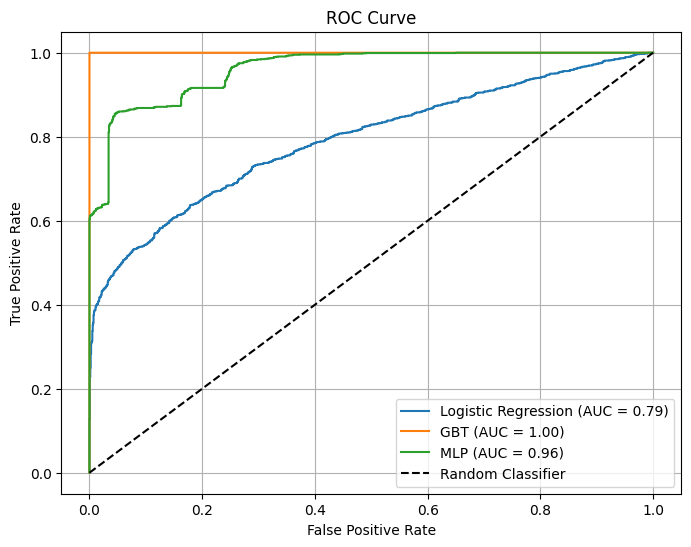

In [26]:
def get_roc_data(predictions, label_col="Dep_Delay_Tag", prob_col="probability"):
    roc_data = predictions.select(prob_col, label_col).rdd.map(lambda row: (float(row[0][1]), float(row[1])))
    roc_data_sorted = roc_data.sortBy(lambda x: -x[0]).collect()

    tp = 0
    fp = 0
    tn = sum(1 for x in roc_data_sorted if x[1] == 0)
    fn = sum(1 for x in roc_data_sorted if x[1] == 1)

    tpr_list = []
    fpr_list = []

    for score, label in roc_data_sorted:
        if label == 1.0:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        tpr = tp / (tp + fn + 1e-10)
        fpr = fp / (fp + tn + 1e-10)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return fpr_list, tpr_list

# Generate ROC data
lr_fpr, lr_tpr = get_roc_data(lr_predictions)
gbt_fpr, gbt_tpr = get_roc_data(gbt_predictions)
mlp_fpr, mlp_tpr = get_roc_data(mlp_predictions)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(gbt_fpr, gbt_tpr, label=f"GBT (AUC = {gbt_auc:.2f})")
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP (AUC = {mlp_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Confusion Matrix Visualization

In this section, we visualize the **Confusion Matrix** for each model (**Logistic Regression**, **Gradient Boosted Tree**, and **Multilayer Perceptron**) to evaluate the models' classification performance. The confusion matrix helps us understand how well the model is classifying the data by showing the true positives, true negatives, false positives, and false negatives.

###  **Confusion Matrix Function**
The function `plot_confusion_matrix` computes the confusion matrix by counting the occurrences of each combination of actual labels and predicted labels. It then plots the confusion matrix using a heatmap.

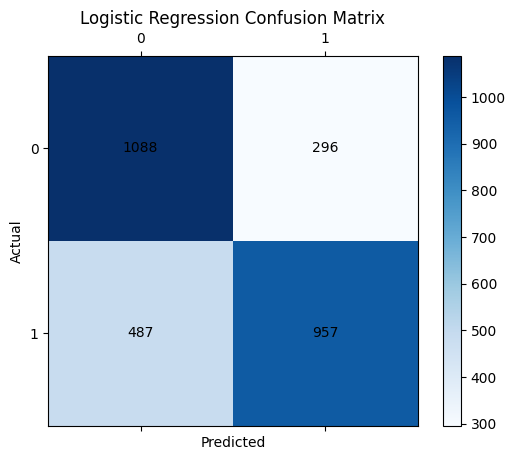

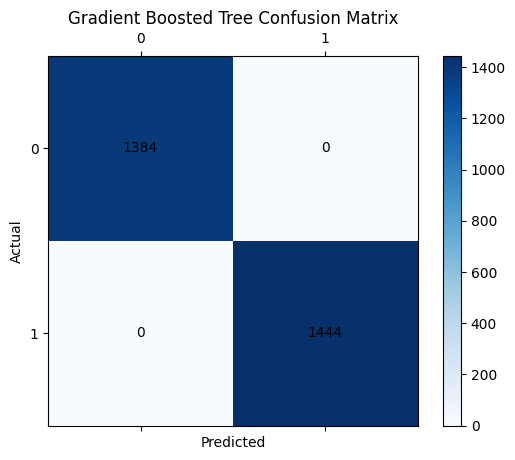

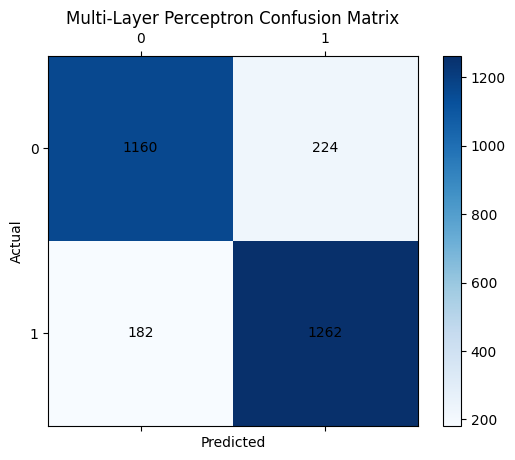

In [27]:
def plot_confusion_matrix(predictions, model_name):
    cm = predictions.groupBy("Dep_Delay_Tag", "prediction").count().collect()
    matrix = [[0, 0], [0, 0]]
    for row in cm:
        i = int(row["Dep_Delay_Tag"])
        j = int(row["prediction"])
        matrix[i][j] = row["count"]

    matrix = np.array(matrix)

    # Plot
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar(cax)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(matrix[i][j]), va='center', ha='center')
    plt.show()

# Plot for each model
plot_confusion_matrix(lr_predictions, "Logistic Regression")
plot_confusion_matrix(gbt_predictions, "Gradient Boosted Tree")
plot_confusion_matrix(mlp_predictions, "Multi-Layer Perceptron")


## Model Performance Comparison

In this section, we compare the performance of three models—**Logistic Regression**, **Gradient Boosted Tree**, and **Multilayer Perceptron**—using multiple evaluation metrics. The following metrics are used for comparison:

- **AUC (Area Under the Curve):** A metric that evaluates the classifier's ability to distinguish between positive and negative classes.
- **Accuracy:** The proportion of correctly classified instances out of all instances.
- **Precision:** The proportion of true positive predictions relative to the total predicted positives.
- **Recall:** The proportion of true positive predictions relative to the actual positives.
- **F1 Score:** The harmonic mean of precision and recall, providing a balance between the two.


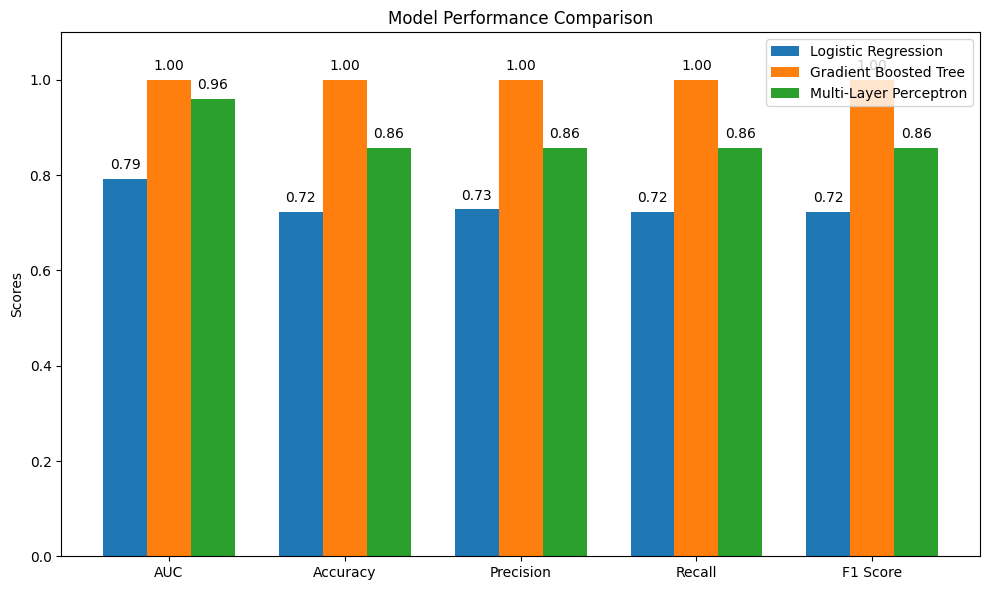

In [28]:
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
lr_values = [lr_auc, lr_accuracy, lr_precision, lr_recall, lr_f1]
gbt_values = [gbt_auc, gbt_accuracy, gbt_precision, gbt_recall, gbt_f1]
mlp_values = [mlp_auc, mlp_accuracy, mlp_precision, mlp_recall, mlp_f1]

x = np.arange(len(metrics))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, lr_values, width, label='Logistic Regression')
rects2 = ax.bar(x, gbt_values, width, label='Gradient Boosted Tree')
rects3 = ax.bar(x + width, mlp_values, width, label='Multi-Layer Perceptron')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

### To save the models for Real time Use

In [ ]:
# import os

# os.makedirs("Trained_Models", exist_ok=True)

# # Saving the Spark models
# lr_model.write().overwrite().save("Trained_Models/lr_model")
# gbt_model.write().overwrite().save("Trained_Models/gbt_model")
# mlp_model.write().overwrite().save("Trained_Models/mlp_model")
# pipeline_model.write().overwrite().save("Trained_Models/pipeline_model")